In [1]:
using Pkg
Pkg.activate("/Users/yusuke/program/julia_module/MyPackage")
using MyPackage

using Healpix
using Plots
using NPZ
using LinearAlgebra
using LsqFit
using StatsBase
using BenchmarkTools
using PyCall
using TickTock
using Base.Threads
using StatsPlots
using PyPlot
using DSP
using FFTW
gr()

hp =  pyimport("healpy")
np = pyimport("numpy")
sns = pyimport("seaborn")
plt = pyimport("matplotlib.pyplot")
sp = pyimport("scipy.optimize")
pd = pyimport("pandas")
nth = nthreads()# for parallerize

@inline function MultiTrack_calculation(
    NSIDE::Integer,
    start::Integer,
    stop::Integer,
    smp_rate::Integer,
    dθ::Array,
    dφ::Array,
)

    loop = ((stop - start) * smp_rate) + 1

    #println("time=",loop)
    res = Resolution(NSIDE)

    α = 45(π / 180)
    β = 50(π / 180)
    orbit3D = zeros(Float64, loop, 3)
    orbit2D = zeros(Float64, loop, 2)
    dif3D = zeros(Float64, loop-1, 3)
    dif2D = zeros(Float64, loop-1, 2)
    theta_axis3D = zeros(Float64, loop, 3)

    theta_axis = zeros(Float64, loop, 2)
    sky_axis = zeros(Float64, loop, 3)

    pix = zeros(Int64, loop, length(dθ))
    psi_i = zeros(Float64, loop, length(dθ))
    cb = cos(β)
    sb = sin(β)
    ca = cos(α)
    sa = sin(α)
    println("Start track calculation!")

    for j in eachindex(dθ)
        println("j=", j)
        #origin =[cos(dθ[j]) * cos(dφ[j]); cos(dθ[j]) * sin(dφ[j]); sin(dθ[j])]
        #=
        origin = [
        cosd(dθ[j]) -sind(dθ[j]) 0
        sind(dθ[j])*cosd(dφ[j]) cosd(dθ[j])*cosd(dφ[j])  -sind(dφ[j])
        sind(dθ[j])*sind(dφ[j]) cosd(dθ[j])*sind(dφ[j])  cosd(dφ[j])
        ]*[1;0;0]
        =#
        origin = [cosd(dθ[j]); sind(dθ[j])cosd(dφ[j]); sind(dθ[j])sind(dφ[j])]

        @inbounds @threads for i in 1:loop
            t = start + (i-1)/smp_rate

            ωₐt = ((2π / 60) / 192.348)t
            ωᵦt = (0.05π / 30)t
            ωᵣt = (2π)t / (60 * 60 * 24 * 365)
            cwb = cos(ωᵦt)
            swb = sin(ωᵦt)
            cwa = cos(ωₐt)
            swa = sin(ωₐt)
            cwr = cos(ωᵣt)
            swr = sin(ωᵣt)

            rot_spin = [
                cb -sb 0
                sb*cwb cb*cwb -swb
                sb*swb cb*swb cwb
            ]
            vec_1 = @views rot_spin * origin

            rot_prec = [
                ca -sa 0
                sa*cwa ca*cwa -swa
                sa*swa ca*swa cwa
            ]
            vec_2 = @views rot_prec * vec_1

            rot_sun = [
                cwr -swr 0
                swr cwr 0
                0 0 1
            ]
            vec_3 = @views rot_sun * vec_2

            orbit3D[i, 1] = vec_3[1]
            orbit3D[i, 2] = vec_3[2]
            orbit3D[i, 3] = vec_3[3]

            ang = @views vec2ang(
                orbit3D[i, 1],
                orbit3D[i, 2],
                orbit3D[i, 3],
            )

            orbit2D[i, 1] = ang[1]
            orbit2D[i, 2] = ang[2]

            theta_axis[i, 1] = orbit2D[i, 1] + (π / 180) * 1e-7

            vec = @views ang2vec(theta_axis[i, 1], orbit2D[i, 2])
            sky_axis[i, 1] = vec[1] - orbit3D[i, 1]
            sky_axis[i, 2] = vec[2] - orbit3D[i, 2]
            sky_axis[i, 3] = vec[3] - orbit3D[i, 3]
            pix[i, j] = ang2pix(m, orbit2D[i, 1], orbit2D[i, 2])
        end

        @inbounds @threads for i in 1:loop-1
            dif3D[i, 1] = orbit3D[i+1, 1] - orbit3D[i, 1]
            dif3D[i, 2] = orbit3D[i+1, 2] - orbit3D[i, 2]
            dif3D[i, 3] = orbit3D[i+1, 3] - orbit3D[i, 3]
            dif2D[i, 1] = orbit2D[i+1, 1] - orbit2D[i, 1]
            dif2D[i, 2] = orbit2D[i+1, 2] - orbit2D[i, 2]

            Vvec = @views dif3D[i, :]
            nvec = @views sky_axis[i, :]
            inner = dot(Vvec, nvec)
            L_dif =
                √(dif3D[i, 1]^2 + dif3D[i, 2]^2 + dif3D[i, 3]^2)
            L_axis = √(
                sky_axis[i, 1]^2 +
                sky_axis[i, 2]^2 +
                sky_axis[i, 3]^2,
            )

            cos_psi = inner / (L_dif * L_axis)

            if dif2D[i, 2] > π
                dif2D[i, 2] = dif2D[i, 2] - 2π
            end
            if dif2D[i, 2] < -π
                dif2D[i, 2] = dif2D[i, 2] + 2π
            end

            judge = sign(-dif2D[i, 2])
            psi_i[i, j] = acos(cos_psi) * judge
        end
    end
    return pix, psi_i
end


function get_psi_and_pix(
    NSIDE::Integer,
    times::Integer,
    smp_rate::Integer,
    dθ::Array,
    dφ::Array,
)

    split_num = 6
    month = Int64(times/split_num)


    hit_pix = zeros(Int64, NPIX)
    theta_line_pix = Int64[]
    theta_line_psi = Float64[]

    Begin = 0
    
    deg = 90(π/180)
    dphi = 20(π/180)

    for i = 1:split_num
        println("process=", i, "/", split_num)
        stop = i*month

        #println("calc_", start, "_to_", stop)
        #println("Finish is =", times)
        PIX, PSI_i = MultiTrack_calculation(NSIDE, Begin, stop, smp_rate, dθ, dφ)

        loop_times = length(PSI_i)
        #println("Start reconstruct!")
        #println("loop_times=", loop_times)
        bore_pix = @views PIX
        #ghost_pix = @views PIX[:, 2]
        psi_i = @views PSI_i
        
        pix_pi2 = hp.pix2ang(NSIDE, bore_pix)[2]
    
        for k in 1:loop_times
            bore = bore_pix[k]
            #ghost = ghost_pix[k]
            psi = psi_i[k]
            TIME = Begin + (k-1)/smp_rate
            
            
            if pix_pi2[k] < deg + dphi
                if pix_pi2[k] > deg - dphi
                    push!(theta_line_pix, bore)
                    push!(theta_line_psi, psi)
                end
            end

            hit_pix[bore] += 1
        end
        Begin = stop + 1
    end
    
    return hit_pix, theta_line_pix, theta_line_psi
end

function dist_FWHM(copol, theta_line_pix, phi90pix)
    @. gaussian2(x, p) = p[1] * exp(-(1/2)*((x/p[2])^2))
    ddeg = np.deg2rad(0.36)
    FWHM = zeros(length(phi90pix)-2, 4)
    p0 = [136, 0.003]
    xdata = @views [reverse(theta[:,1]) ; -theta[:,500]]
    idx1 = [1, 125, 250, 375]
    idx2 = 500 .+ idx1
    
    for i in 2:99
        if i%10 == 0
            println(i)
        end
        
        index = np.where(theta_line_pix .== phi90pix[i])[1] .+1

        psi_in_ipix = zeros(length(index))
        @threads for i in eachindex(index)
            psi_in_ipix[i] = theta_line_psi[index[i]] 
        end

        copol_sym = MyPackage.rot_beam(psi_in_ipix, copol)
        
        for j in 1:4
            ydata = @views [reverse(copol_sym[:,idx1[j]])  ;copol_sym[:,idx2[j]]]
            Fit = curve_fit(gaussian2, xdata, ydata, p0)
            FWHM[i-1,j] = 60*2*√(2*log(2))* (Fit.param[2])*(180/π)
        end

        #println(FWHM[i])
    end
    return FWHM
end

function hit_map(NSIDE, pix)
    NPIX = nside2npix(NSIDE)
    hit_pix = zeros(Int64, NPIX)
    @threads for i = 1:length(pix)
        hit_pix[pix[i]] += 1
    end
    return hit_pix
end

 Activating environment at `~/program/julia_module/MyPackage/Project.toml`


hit_map (generic function with 1 method)

In [2]:
const NSIDE = 128
const NPIX = nside2npix(NSIDE)
const m = Map{Float64,RingOrder}(NSIDE)
const day = 60 * 60 * 24
const year = day * 365
smp_rate = 5
times = year

println("SR=", smp_rate)


SR=5


In [3]:
df = pd.read_csv("/Users/yusuke/program/LiteBIRD_sim/beam_study/20200727_pointing_16mm.csv")
beam_path = "/Users/yusuke/program/LiteBIRD_sim/beam_study/beam_data/FWHM_study/use_data/npz_data/m92_p92_blue/m92_p92_78G_000deg_tp.npz"

file_name = split(beam_path, "/")
main_name = split(file_name[12],".npz")[1]

detctor_position = split(main_name , "_")[1] * "_" *split(main_name , "_")[2]
get_detec = df["file_name"].str.contains(detctor_position)
index = np.where(get_detec .== true)[1] .+1


┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at In[3]:8
└ @ Core In[3]:8


3-element Array{Int64,1}:
 1
 2
 3

In [4]:
param = df.loc[index[1]]
THETA = param[5]
PHI = param[6]-180
println(param)
println("THETA=", THETA)
println("PHI=", PHI)

PyObject file_name    m92_p92_78G
wafer                  2
pixel                  5
freq                  78
theta               6.24
phi                133.2
Name: 0, dtype: object


┌ Warning: `getindex(o::PyObject, i::Integer)` is deprecated, use `get(o, i - 1)` instead.
│   caller = top-level scope at In[4]:1
└ @ Core In[4]:1
┌ Warning: `getindex(o::PyObject, i::Integer)` is deprecated, use `get(o, i - 1)` instead.
│   caller = top-level scope at In[4]:2
└ @ Core In[4]:2
┌ Warning: `getindex(o::PyObject, i::Integer)` is deprecated, use `get(o, i - 1)` instead.
│   caller = top-level scope at In[4]:3
└ @ Core In[4]:3


THETA=6.24
PHI=-46.80000000000001


Start track calculation!
j=1


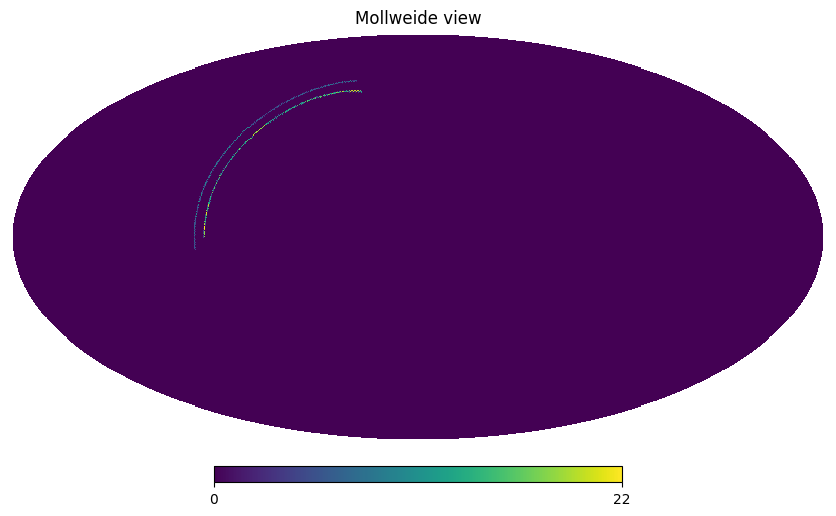

j=2
j=3


In [5]:
#THETA = 4.8
#PHI = 152.64-180
th = [0, 0, THETA]
ph = [0, 0, PHI]
pix, psi_i= MultiTrack_calculation(NSIDE, 0, 300, smp_rate, th, ph)
#pix2, psi_i = MultiTrack_calculation(NSIDE, 0, 300, smp_rate, [0,0], [0,0])
#pix
I_lu = hit_map(NSIDE, pix)
#plot(gen_map(NSIDE, I_lu), c=:jet, fmt=:png)
hp.mollview(I_lu)

In [6]:
dth = [THETA]
dph = [PHI]
tick()
hit_pix, theta_line_pix, theta_line_psi = get_psi_and_pix(NSIDE, times, smp_rate, dth, dph)
tock()

┌ Info:  started timer at: 2020-08-28T11:57:25.319
└ @ TickTock /Users/yusuke/.julia/packages/TickTock/3F6de/src/TickTock.jl:32


process=1/6
Start track calculation!
j=1
process=2/6
Start track calculation!
j=1
process=3/6
Start track calculation!
j=1
process=4/6
Start track calculation!
j=1
process=5/6
Start track calculation!
j=1
process=6/6
Start track calculation!
j=1


┌ Info:        517.218760215s: 8 minutes, 37 seconds, 218 milliseconds
└ @ TickTock /Users/yusuke/.julia/packages/TickTock/3F6de/src/TickTock.jl:39


In [7]:
#Theta_line, phi90pix = MyPackage.lineget(NSIDE, theta_line_pix, theta_line_psi, 256)
div = 100
elev = np.linspace(0, π, div)
azim = ones(div) .* π / 2
phi90pix = hp.ang2pix(NSIDE, elev, azim)
#np.save("/Users/yusuke/program/LiteBIRD_sim/beam_study", phi90pix)
div

100

In [30]:

beam_path = "/Users/yusuke/program/LiteBIRD_sim/beam_study/beam_data/FWHM_study/use_data/npz_data/m92_p92_blue/m92_p92_100G_000deg_tp.npz"
file_name = split(beam_path, "/")
main_name = split(file_name[12],".npz")[1]

data = npzread(beam_path)

N = 1001
phi = np.deg2rad(np.reshape(data["phi"], [N, N]))
theta = np.deg2rad(np.reshape(data["theta"], [N, N]))
X = theta .* cos.( phi )
Y = theta .* sin.( phi )
copol = np.reshape(data["copol"], [N, N])
length(theta)


1002001

pix=[89.10471701342988, 90.0]


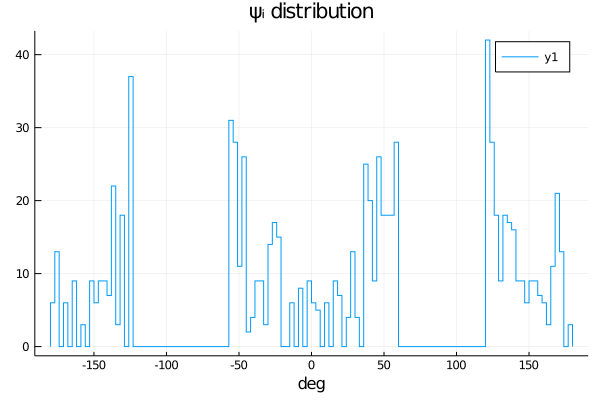

In [53]:
#print(Int.(Theta_line[1,:])[220])
#index = np.where(Int.(Theta_line[1,:]) .==52608)[1] .+1
pixnmb = 50
index = np.where(theta_line_pix .== phi90pix[pixnmb])[1] .+1

psi_in_ipix = zeros(length(index))
for i in 1:length(index)
    psi_in_ipix[i] = theta_line_psi[index[i]] 
end
ddeg = np.deg2rad(0.36)
println("pix=",np.rad2deg(hp.pix2ang(NSIDE,phi90pix[pixnmb])))

copol = np.reshape(data["copol"], [N, N])
copol_sym = MyPackage.rot_beam(psi_in_ipix, copol)

edge = -180:3:180

psi_dist = fit(Histogram, np.rad2deg(psi_in_ipix), edge)

Plots.plot(psi_dist,
    title = "ψᵢ distribution",
    xlabel="deg",
    seriestype = :step, fmt=:png)

[140504.43541615971, 0.0035263113244691224]
FWHM=28.54645992688549


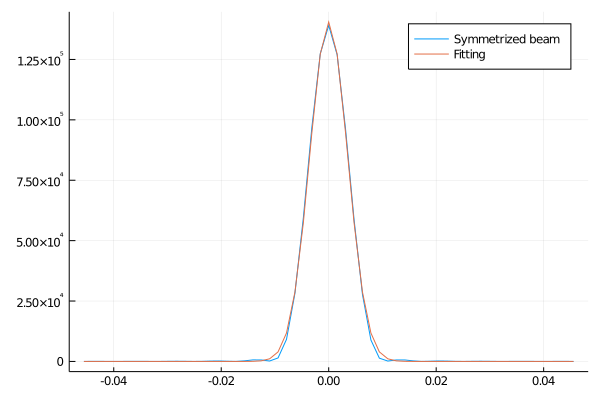

In [49]:
@. gaussian2(x, p) = p[1] * exp(-(1/2)*((x/p[2])^2))

cut=30
a = [reverse(copol_sym[1:cut,1])  ;copol_sym[1:cut,501]]
b = [reverse(theta[1:cut,1]) ; -theta[1:cut,501]]


p0 = [106804, 0.000487]
xdata = b
ydata = a

Fit = curve_fit(gaussian2, xdata, ydata, p0)
println(Fit.param)

gauss = gaussian2(xdata, Fit.param)
FWHM = 2*√(2*log(2))*Fit.param[2]
println("FWHM=", np.rad2deg(FWHM)*60)
Plots.plot(xdata, ydata, label = "Symmetrized beam", fmt=:png)
Plots.plot!(xdata, gauss, label = "Fitting")

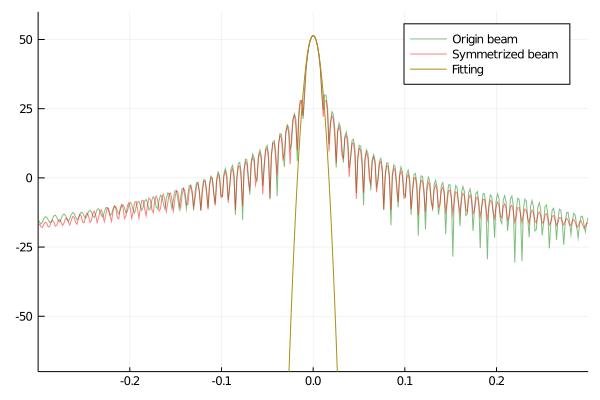

In [50]:
Plots.plot( theta[:,1], 10log10.(copol[:,1]), color=:green, alpha=0.5, label="Origin beam", fmt=:png)
Plots.plot!( -theta[:,500], 10log10.(copol[:,500]), color=:green, alpha=0.5, label=:none)

Plots.plot!( theta[:,1], 10log10.(copol_sym[:,1]), color=:red, alpha=0.5, label="Symmetrized beam")
Plots.plot!( -theta[:,501], 10log10.(copol_sym[:,501]), color=:red, alpha=0.5, label=:none)

Plots.plot!(xdata, 10log10.(gauss), label = "Fitting", xlim=(-0.3,0.3),ylims=(-70,60), fmt=:png)

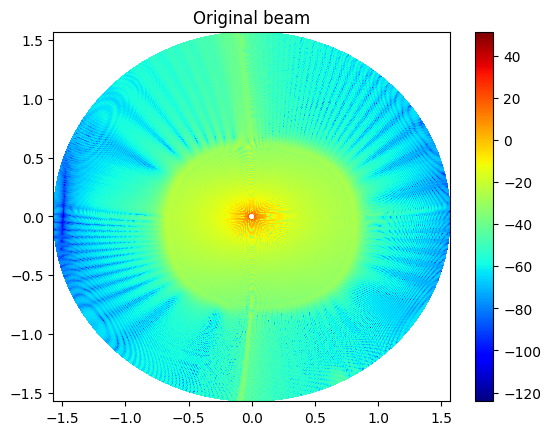

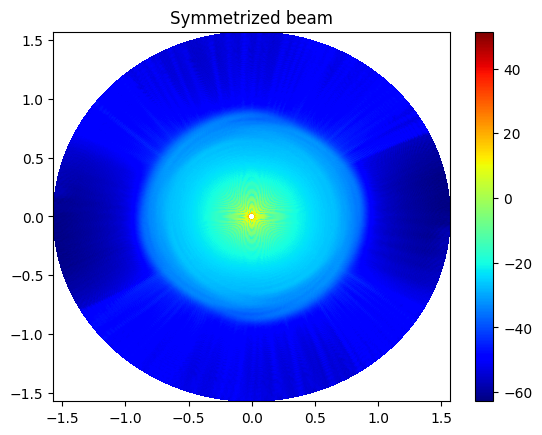

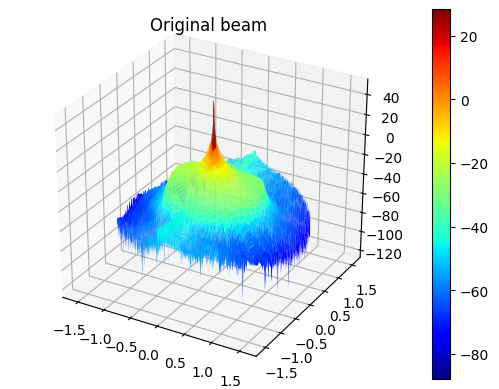

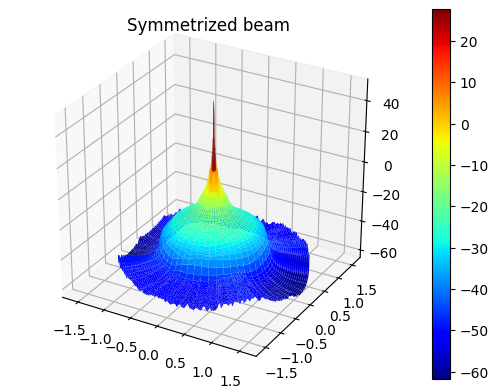

PyObject Text(0.5, 0.92, 'Symmetrized beam')

In [51]:
figure(111)
plt.title("Original beam")
pcolormesh(X, Y, 10log10.(copol), cmap = "jet" )
pp = plt.colorbar( orientation ="vertical")


figure(222)
plt.title("Symmetrized beam")
pcolormesh(X, Y, 10log10.(copol_sym), cmap = "jet" )
pp = plt.colorbar( orientation ="vertical")

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(X, Y, 10log10.(copol), cmap="jet", linewidth=0)
fig.colorbar(surf)
ax.set_title("Original beam")

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(X, Y, 10log10.(copol_sym), cmap="jet", linewidth=0)
fig.colorbar(surf)
ax.set_title("Symmetrized beam")

In [36]:
function dist_FWHM(copol, theta_line_pix, phi90pix, p0)
    @. gaussian2(x, p) = p[1] * exp(-(1/2)*((x/p[2])^2))
    ddeg = np.deg2rad(0.36)
    FWHM = zeros(length(phi90pix), 4)
    #p0 = [50435, 0.00487]
    xdata = @views [reverse(theta[:,1]) ; -theta[:,500]]
    idx1 = [1, 125, 250, 375]
    idx2 = 500 .+ idx1
    
    for i in eachindex(phi90pix)
        if i%10 == 0
            println(i)
        end
        
        index = np.where(theta_line_pix .== phi90pix[i])[1] .+1

        psi_in_ipix = zeros(length(index))
        @threads for i in eachindex(index)
            psi_in_ipix[i] = theta_line_psi[index[i]] 
        end
        
        if length(psi_in_ipix) != 0
            copol_sym = MyPackage.rot_beam(psi_in_ipix, copol)

            for j in 1:4
                ydata = @views [reverse(copol_sym[:,idx1[j]])  ;copol_sym[:,idx2[j]]]
                Fit = curve_fit(gaussian2, xdata, ydata, p0)
                FWHM[i,j] = 60*2*√(2*log(2))* (Fit.param[2])*(180/π)
            end
        end
    end
    return FWHM
end

fwhm = dist_FWHM(copol, theta_line_pix, phi90pix, p0)

10
20
30
40
50
60
70
80
90
100


100×4 Array{Float64,2}:
  0.0      0.0      0.0      0.0
 28.6694  28.656   28.6466  28.6601
 28.6635  28.643   28.6518  28.6734
 28.6906  28.6591  28.6254  28.6565
 28.7092  28.6649  28.6065  28.6507
 28.8411  28.6954  28.4779  28.6163
 28.6109  28.6427  28.6989  28.6789
 28.5022  28.641   28.8099  28.6794
 28.5112  28.6577  28.8027  28.6615
 28.4572  28.6394  28.8557  28.6813
 28.4327  28.6334  28.8835  28.6842
 28.4378  28.6746  28.8813  28.641
 28.4083  28.6309  28.9096  28.6854
  ⋮                         
 28.4655  28.6601  28.8481  28.6587
 28.4144  28.6679  28.9043  28.6474
 28.4522  28.6146  28.8615  28.7042
 28.4725  28.6252  28.841   28.6937
 28.5334  28.6738  28.777   28.6489
 28.5991  28.6725  28.7125  28.6495
 28.8293  28.68    28.4917  28.6336
 28.7095  28.6537  28.6075  28.6623
 28.6783  28.6491  28.6385  28.6668
 28.6795  28.6795  28.6361  28.6377
 28.6652  28.6205  28.6497  28.6965
  0.0      0.0      0.0      0.0

In [37]:
loop = length(np.nonzero(fwhm[:,1])[1])
FWHM_ = zeros(loop, 4)
for i in 1:loop
    @threads for j in 1:4
        FWHM_[i,j] = fwhm[i+Int((100-loop)/2),j]
    end
end


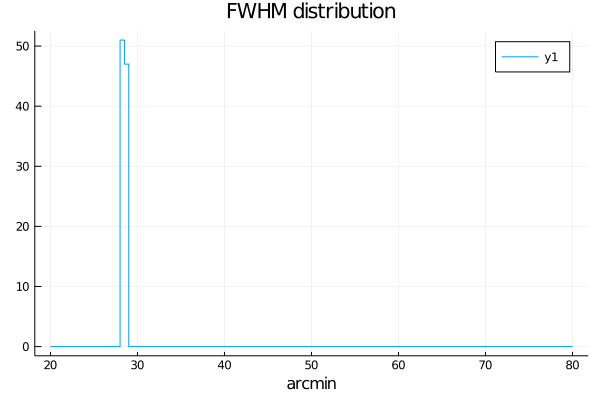

In [44]:
edge = 20:0.5:80
fwhm_dist = fit(Histogram, FWHM_[:,1], edge)

Plots.plot(fwhm_dist,
    title = "FWHM distribution",
    xlabel="arcmin",
    seriestype = :step, fmt=:png)

In [239]:
savepath = "/Users/yusuke/program/LiteBIRD_sim/beam_study/beam_data/calc_fwhm_dist/"
np.savez_compressed(savepath * main_name * "_fwhm", data=FWHM_)

In [240]:
a = npzread(savepath * main_name * "_fwhm" * ".npz")
a["data"]

98×4 Array{Float64,2}:
 43.8377  43.8495  43.8519  43.8401
 43.8547  43.8103  43.8343  43.8799
 43.8799  43.8337  43.81    43.8561
 43.8765  43.8444  43.8142  43.8452
 43.9506  43.7949  43.7402  43.8943
 44.0774  43.7205  43.6158  43.9659
 43.7266  43.8619  43.9551  43.8366
 43.6492  43.9576  44.0352  43.7403
 43.6183  43.9821  44.0684  43.7133
 43.534   43.9626  44.1544  43.7311
 43.5195  43.9838  44.1704  43.7091
 43.5678  43.9799  44.1269  43.7083
 43.5006  43.9635  44.1906  43.7275
  ⋮                         
 43.5095  43.9556  44.1808  43.7376
 43.5821  43.9017  44.106   43.7926
 43.6459  44.0082  44.0411  43.6877
 43.5409  43.896   44.1441  43.8001
 43.6879  43.9784  43.9942  43.7201
 43.7551  43.8273  43.9262  43.8698
 44.1278  43.744   43.5614  43.9414
 43.958   43.8381  43.7305  43.8501
 43.8912  43.816   43.7973  43.873
 43.8676  43.8582  43.8213  43.8314
 43.8561  43.8172  43.833   43.8721
 43.8536  43.8649  43.836   43.824